# Home Credit Default Risk

# Part 1 : Azure ML Studio setup

In [1]:
# Handle to the workspace
from azure.ai.ml import MLClient

# Authentication package
from azure.identity import DefaultAzureCredential

credential = DefaultAzureCredential()

In [2]:
# Get a handle to the workspace
ml_client = MLClient(
    credential=credential,
    subscription_id="6df20682-3fc5-48fd-98e3-927f1ffaf36b",
    resource_group_name="antoine.naudy-rg",
    workspace_name="formation",)

In [3]:
from azure.ai.ml.entities import AmlCompute

# Name assigned to the compute cluster
cpu_compute_target = "PDS6"#"cpu-cluster"

try:
    # let's see if the compute target already exists
    cpu_cluster = ml_client.compute.get(cpu_compute_target)
    print(
        f"You already have a cluster named {cpu_compute_target}, we'll reuse it as is."
    )

except Exception:
    print("Creating a new cpu compute target...")

    # Let's create the Azure ML compute object with the intended parameters
    cpu_cluster = AmlCompute(
        name=cpu_compute_target,
        # Azure ML Compute is the on-demand VM service
        type="amlcompute",
        # VM Family
        size="STANDARD_DS3_V2",
        # Minimum running nodes when there is no job running
        min_instances=0,
        # Nodes in cluster
        max_instances=4,
        # How many seconds will the node running after the job termination
        idle_time_before_scale_down=180,
        # Dedicated or LowPriority. The latter is cheaper but there is a chance of job termination
        tier="Dedicated",
    )
    print(
         f"AMLCompute with name {cpu_cluster.name} will be created, with compute size {cpu_cluster.size}"
          )
    # Now, we pass the object to MLClient's create_or_update method
    cpu_cluster = ml_client.compute.begin_create_or_update(cpu_cluster)

You already have a cluster named PDS6, we'll reuse it as is.


In [4]:
# Create a job environment
import os

dependencies_dir = "./dependencies"
os.makedirs(dependencies_dir, exist_ok=True)

In [5]:
%%writefile {dependencies_dir}/conda.yml
# Give the requirement for the virtual environment
name: model-env
channels:
  - conda-forge
dependencies:
  - python=3.8
  - numpy=1.21.2
  - pip=21.2.4
  - scikit-learn=0.24.2
  - scipy=1.7.1
  - pandas>=1.1,<1.2
  - pip:
    - inference-schema[numpy-support]==1.3.0
    - xlrd==2.0.1
    - mlflow== 1.26.1
    - azureml-mlflow==1.42.0
    - psutil>=5.8,<5.9
    - tqdm>=4.59,<4.60
    - ipykernel~=6.0
    - matplotlib
    - lightgbm

Overwriting ./dependencies/conda.yml


In [6]:
# Create the virtual environment
from azure.ai.ml.entities import Environment

custom_env_name = "aml-scikit-learn"

pipeline_job_env = Environment(
    name=custom_env_name,
    description="Custom environment for Credit Card Defaults pipeline",
    tags={"scikit-learn": "0.24.2"},
    conda_file=os.path.join(dependencies_dir, "conda.yml"),
    image="mcr.microsoft.com/azureml/openmpi3.1.2-ubuntu18.04:latest",
)
pipeline_job_env = ml_client.environments.create_or_update(pipeline_job_env)

print(
    f"Environment with name {pipeline_job_env.name} is registered to workspace, the environment version is {pipeline_job_env.version}"
)

Environment with name aml-scikit-learn is registered to workspace, the environment version is 78


# Part 2 : Cleaning

Cleaned dataset df was retrieved from "https://www.kaggle.com/code/brandonsfick/group-2-v01"

In [7]:
# pip install lightgbm

In [8]:
# pip install ydata_profiling

In [9]:
# Import generic libraries
import pandas as pd
import numpy as np

In [10]:
# Load dataset
df = pd.read_csv("df.csv")

In [11]:
df.describe()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
count,356251.00000,3.562510e+05,3.562510e+05,3.562510e+05,356251.000000,356251.000000,356251.000000,356251.000000,356251.000000,356251.000000,...,3.562510e+05,3.562510e+05,3.562510e+05,3.562510e+05,3.562510e+05,3.562510e+05,356251.000000,356251.000000,356251.000000,356251.000000
mean,27425.64439,5.877695e+05,5.280212e+05,1.701159e+05,0.006282,0.005809,0.231691,0.304400,0.029995,1.911544,...,1.861580e+04,6.831305e+05,5.282777e+03,1.400443e+05,1.900386e+04,6.904888e+05,-328.436694,-922.094466,-42103.193758,40.064320
std,14732.11653,3.986253e+05,3.659228e+05,2.235080e+05,0.097041,0.074223,0.796749,0.732501,0.178141,1.736337,...,2.290970e+04,8.722212e+05,1.415532e+04,2.437429e+05,2.463383e+04,9.088526e+05,524.641540,583.039681,55517.090378,40.081355
min,1615.50000,4.500000e+04,4.050000e+04,2.565000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,2.250000e-01,1.890000e-01,0.000000e+00,-3071.000000,-3071.000000,-602499.000000,1.000000
25%,16731.00000,2.700000e+05,2.340000e+05,1.125000e+05,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,8.114828e+03,1.432370e+05,4.909500e+01,1.501960e+04,7.792700e+03,1.392739e+05,-364.000000,-1284.127016,-47547.000000,12.000000
50%,25078.50000,5.002110e+05,4.500000e+05,1.530000e+05,0.000000,0.000000,0.000000,0.000000,0.000000,1.911544,...,1.331709e+04,3.648386e+05,2.842110e+03,4.148572e+04,1.299874e+04,3.547237e+05,-83.000000,-848.328767,-23083.000000,27.000000
75%,34960.50000,7.975575e+05,6.750000e+05,2.025000e+05,0.000000,0.000000,0.231691,0.304400,0.000000,3.000000,...,2.095620e+04,8.155875e+05,6.846030e+03,1.400443e+05,2.092264e+04,8.066012e+05,-27.000000,-450.666667,-7351.500000,49.000000
max,258025.50000,4.050000e+06,4.050000e+06,1.170000e+08,9.000000,4.000000,27.000000,261.000000,8.000000,25.000000,...,2.504590e+06,3.247978e+07,2.504590e+06,3.771488e+06,2.504590e+06,3.268928e+07,-1.000000,-3.000000,0.000000,372.000000


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356251 entries, 0 to 356250
Columns: 506 entries, AMT_ANNUITY to INSTAL_COUNT
dtypes: float64(331), int64(175)
memory usage: 1.3 GB


In [13]:
df.loc[df['TARGET'].isin([0, 1])]

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
0,24700.5,406597.5,351000.0,202500.0,0.000000,0.000000,0.000000,0.0000,0.000000,1.000000,...,11559.247105,219625.695,9251.775,53093.745,11559.247105,219625.695,-49.0,-315.421053,-5993.0,19.0
1,35698.5,1293502.5,1129500.0,270000.0,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,...,64754.586000,1618864.650,6662.970,560835.360,64754.586000,1618864.650,-544.0,-1385.320000,-34633.0,25.0
2,6750.0,135000.0,135000.0,67500.0,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,...,7096.155000,21288.465,5357.250,10573.965,7096.155000,21288.465,-727.0,-761.666667,-2285.0,3.0
3,29686.5,312682.5,297000.0,135000.0,0.006282,0.005809,0.231691,0.3044,0.029995,1.911544,...,62947.088438,1007153.415,2482.920,691786.890,62947.088438,1007153.415,-12.0,-271.625000,-4346.0,16.0
4,21865.5,513000.0,513000.0,121500.0,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,...,12666.444545,835985.340,0.180,22678.785,12214.060227,806127.975,-14.0,-1032.242424,-68128.0,66.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307502,27558.0,254700.0,225000.0,157500.0,0.006282,0.005809,0.231691,0.3044,0.029995,1.911544,...,7492.924286,52450.470,6605.910,12815.010,7492.924286,52450.470,-38.0,-156.285714,-1094.0,7.0
307503,12001.5,269550.0,225000.0,72000.0,0.006282,0.005809,0.231691,0.3044,0.029995,1.911544,...,10069.867500,60419.205,10046.880,10074.465,10069.867500,60419.205,-2327.0,-2393.833333,-14363.0,6.0
307504,29979.0,677664.0,585000.0,153000.0,0.000000,1.000000,1.000000,0.0000,0.000000,1.000000,...,4399.707857,61595.910,27.270,5575.185,4115.915357,57622.815,-1738.0,-2387.428571,-33424.0,14.0
307505,20205.0,370107.0,319500.0,171000.0,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,...,10239.832895,194556.825,2296.440,19065.825,10239.832895,194556.825,-18.0,-161.263158,-3064.0,19.0


In [14]:
# Load sample for analysis
df_tot = pd.read_csv("df.csv").sample(20000)

In [15]:
# pour erreur d'imputation de la moy pour la colonne 'TARGET
import numpy as np

df_tot.loc[~df_tot['TARGET'].isin([0, 1]), 'TARGET'] = np.nan
df_tot1 = df_tot.loc[df_tot['TARGET'].isin([0, 1]),:]

In [16]:
# imputation de la moyenne aux cellules vides
lc = list(df_tot1.columns)
lc.remove('TARGET')
lc.remove('SK_ID_CURR')

for i in lc :
    moy = df_tot1[i].mean()
    df_tot1[i] = df_tot1[i].fillna(moy)

/tmp/ipykernel_5770/1374620480.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tot1[i] = df_tot1[i].fillna(moy)


In [17]:
#déjà fait dans l'EDA
# Suppression des colonnes de score EXT_SOURCE et df_index (data leak)
data_leak = [i for i in df_tot1.columns if i.startswith('EXT_SOURCE')]
df_tot1 = df_tot1.drop(columns=data_leak)

In [18]:
# df_train
df = df_tot1.loc[df_tot1['TARGET']==df_tot1['TARGET'],:]

In [19]:
# Describe the data
from ydata_profiling import ProfileReport
profile = ProfileReport(df_tot, minimal=True)
profile.to_file("report.html")

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Summarize dataset:  50%|████▉     | 254/511 [00:02<00:02, 126.95it/s, Describe variable:PREV_AMT_DOWN_PAYMENT_MIN]/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
Summarize dataset:  50%|████▉     | 255/511 [00:02<00:02, 126.95it/s, Describe variable:PREV_AMT_CREDIT_MEAN]     /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract
 

In [20]:
# at this stage check that 'TARGET is only 0 and 1 
df['TARGET'].unique()

array([0., 1.])

In [21]:
# load dataset

df_ = df.drop(columns=['SK_ID_CURR', 'TARGET'])

# calculate correlation matrix

corr_matrix = df_.corr().abs()

In [22]:
df_

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
161973,53455.5,1258650.0,1125000.0,292500.0,0.000000,0.000000,0.000000,2.0000,0.000000,7.000000,...,64112.543514,4744328.220,2388.645,651106.845,76377.571419,5651940.285,-58.0,-1028.310811,-76095.0,74.0
305410,28737.0,536917.5,463500.0,184500.0,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,...,11333.119091,124664.310,24.525,11328.660,10301.011364,113311.125,-1566.0,-1709.545455,-18805.0,11.0
207364,13788.0,244584.0,193500.0,135000.0,0.000000,0.000000,0.000000,0.0000,0.000000,4.000000,...,20062.815789,1143580.500,756.765,153208.260,19912.305000,1135001.385,-49.0,-524.736842,-29910.0,57.0
59249,17383.5,270000.0,270000.0,292500.0,0.000000,0.000000,0.000000,0.0000,0.000000,2.000000,...,5107.470000,45967.230,3859.605,15090.390,5107.470000,45967.230,-144.0,-272.888889,-2456.0,9.0
57230,23773.5,808650.0,675000.0,189000.0,0.000000,0.000000,0.000000,1.0000,0.000000,0.000000,...,48556.800000,242784.000,8458.020,208951.920,48556.800000,242784.000,-763.0,-832.200000,-4161.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275745,12717.0,296280.0,225000.0,137025.0,0.006282,0.005809,0.231691,0.3044,0.029995,1.911544,...,7301.336250,87616.035,1279.305,27962.010,6851.197500,82214.370,-14.0,-1008.250000,-12099.0,12.0
227784,41692.5,1288350.0,1125000.0,405000.0,0.000000,0.000000,0.000000,0.0000,0.000000,2.000000,...,3105.750937,49692.015,2143.485,5617.845,3456.866250,55309.860,-508.0,-722.562500,-11561.0,16.0
285330,16551.0,156384.0,135000.0,67500.0,0.000000,0.000000,0.000000,0.0000,1.000000,3.000000,...,33163.852500,198983.115,33158.790,33164.865,33163.852500,198983.115,-577.0,-654.000000,-3924.0,6.0
101952,13500.0,270000.0,270000.0,112500.0,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,...,12313.590750,246271.815,3.330,40926.465,12114.960750,242299.215,-170.0,-760.600000,-15212.0,20.0


In [23]:
# get upper triangle of correlation matrix

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# find features with correlation greater than 0.90

to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

# drop highly correlated features

df_.drop(to_drop, axis=1, inplace=True)

/tmp/ipykernel_5770/3087656708.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


In [24]:
df_.shape

(17188, 440)

# Part 3 : Exploratory Data Analysis

In [25]:
import matplotlib.pyplot as plt

risky = df.loc[df['TARGET']==1,'SK_ID_CURR']
safe = df.loc[df['TARGET']==0,'SK_ID_CURR']

def labeler(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

sizes = [len(risky),len(safe)] # wedge sizes

fig0, ax1 = plt.subplots(figsize=(6,6))
wedges, texts, autotexts = ax1.pie(sizes,
                                   autopct=lambda pct: labeler(pct, sizes),
                                   radius=1,
                                   colors=['#0066ff','#cc66ff'],
                                   startangle=90,
                                   textprops=dict(color="w"),
                                   wedgeprops=dict(width=0.7, edgecolor='w'))

ax1.legend(wedges, ['risky','safe'],
           loc='center right',
           bbox_to_anchor=(0.7, 0, 0.5, 1))

plt.text(0,0, 'TOTAL\n{}'.format(len(risky)+len(safe)),
         weight='bold', size=12, color='#52527a',
         ha='center', va='center')

plt.setp(autotexts, size=12, weight='bold')
ax1.axis('equal')  # Equal aspect ratio

# Sauvegarder l'image du graphe
plt.savefig('partition_target.png')

plt.show()

# Part 4 : Model selection

In [26]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## 4-1 : Balancing data with SMOTE

In [27]:
# Import libraries for preprocessing
import time

from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import auc, roc_curve, accuracy_score, roc_auc_score 
from sklearn.metrics import det_curve

from sklearn.model_selection import train_test_split, GridSearchCV

In [28]:
# Data split
from sklearn.preprocessing import RobustScaler

X = df_.values
y = df['TARGET'].values

# Fix for error
from sklearn import preprocessing
from sklearn import utils

#convert y values to categorical values
lab = preprocessing.LabelEncoder()
y = lab.fit_transform(y)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [29]:
#pip install imblearn

In [30]:
# Model use for SMOTE testing
model = DecisionTreeClassifier() 

In [31]:
X_train = np.nan_to_num(X_train.astype(np.float32))
X_test = np.nan_to_num(X_test.astype(np.float32))

In [32]:
X_train.dtype

dtype('float32')

# First option : borderline-SMOTE for imbalanced dataset
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import BorderlineSMOTE, SVMSMOTE
from matplotlib import pyplot
from numpy import where
from sklearn.metrics import confusion_matrix


%pylab inline
# summarize class distribution
counter = Counter(y_train)
print(counter)
# transform the dataset
oversample = BorderlineSMOTE()
X_, y_ = oversample.fit_resample(X_train, y_train)

# summarize the new class distribution
counter = Counter(y_)
print(counter)

# scatter plot of examples by class label
for label, _ in counter.items():
 row_ix = where(y_ == label)[0]
 pyplot.scatter(X_[row_ix, 0], X_[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

# prediction
clf = GridSearchCV(model,
            param_grid={},
            cv=5,
            scoring='roc_auc',
            verbose=2)
clf.fit(X_,y_)

# Train scoring
print('Train results: ','\nModel: ', clf.best_estimator_, '\nBest parameters: ', clf.best_params_, '\nBest ROC AUC: %.2f' % clf.best_score_)
y_pred = clf.predict(X_test)

#fpr, fnr, thresholds = det_curve(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='all').ravel()

# Test scoring
print('Test results: ')
print('Cost (10fn+fp): {:.2f}'.format(10*fn + fp))
print('AUC: %.2f' % roc_auc_score(y_test, y_pred))
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

# Second option : borderline-SMOTE with SVM for imbalanced dataset

%pylab inline
# summarize class distribution
counter = Counter(y)
print(counter)
# transform the dataset
oversample = SVMSMOTE()
X_, y_ = oversample.fit_resample(X_train, y_train)
# summarize the new class distribution
counter = Counter(y_)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
 row_ix = where(y_ == label)[0]
 pyplot.scatter(X_[row_ix, 0], X_[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

# Fitting model
clf = GridSearchCV(model,param_grid={},cv=5,scoring='roc_auc',verbose=2)
clf.fit(X_,y_)
y_pred = clf.predict(X_test)

# Train scoring
print('Train results: ','\nModel: ', clf.best_estimator_, '\nBest parameters: ', clf.best_params_, '\nBest ROC AUC: %.2f' % clf.best_score_)
y_pred = clf.predict(X_test)
#fpr, fnr, thresholds = det_curve(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='all').ravel()

# Test scoring
print('Test results: ')
print('Cost (10fn+fp): {:.2f}'.format(10*fn + fp))
print('AUC: %.2f' % roc_auc_score(y_test, y_pred))
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

We choose BorderlineSMOTE() with SVM over borderline-SMOTE. the first Borderline has a better scores with the baseline model DecisionTreeClassifier

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
Counter({0: 12642, 1: 1108})
Counter({0: 12642, 1: 12642})


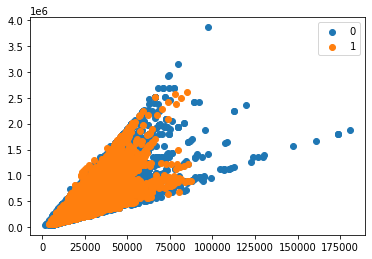

In [33]:
# borderline-SMOTE with SVM for imbalanced dataset (data are already normalized)
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SVMSMOTE, BorderlineSMOTE

%pylab inline
# summarize class distribution
counter = Counter(y_train)
print(counter)
# transform the dataset
oversample = BorderlineSMOTE()
X_, y_ = oversample.fit_resample(X_train, y_train)
# summarize the new class distribution
counter = Counter(y_)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
 row_ix = where(y_ == label)[0]
 pyplot.scatter(X_[row_ix, 0], X_[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

## 4-2 : Model testing

In [34]:
import time

from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.metrics import roc_auc_score, roc_curve, recall_score, f1_score, precision_recall_fscore_support


In [35]:
# Custom score function
from sklearn.metrics import make_scorer, det_curve

def cost_function(y_test, y_pred):
    fpr, fnr, thresholds = det_curve(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='all').ravel()
    return 10*fn + fp

custom_scorer = make_scorer(cost_function, greater_is_better=False)

In [36]:
# Confusion matrix function
from sklearn.metrics import confusion_matrix
import seaborn as sns

def confmat(y_test, y_pred):

    conf_matrix = confusion_matrix(y_test, y_pred, normalize='all')
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='all').ravel()
    print('fp : ',fp,'\ntn : ', fn)

    # Change figure size and increase dpi for better resolution
    plt.figure(figsize=(8,6), dpi=100)
    # Scale up the size of all text
    sns.set(font_scale = 1.1)

    # Plot Confusion Matrix using Seaborn heatmap()
    # Parameters:
    # first param - confusion matrix in array format   
    # annot = True: show the numbers in each heatmap cell
    # fmt = 'd': show numbers as integers. 
    ax = sns.heatmap(conf_matrix, annot=True, fmt='.2g')

    # set x-axis label and ticks. 
    ax.set_xlabel("Predicted", fontsize=14, labelpad=20)
    ax.xaxis.set_ticklabels(['0', '1'])

    # set y-axis label and ticks
    ax.set_ylabel("Actual", fontsize=14, labelpad=20)
    ax.yaxis.set_ticklabels(['0', '1'])

    # set plot title
    ax.set_title("Confusion Matrix for credit default", fontsize=14, pad=20)

    plt.show()

In [37]:
# Definition of the models to train and test

from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randint

# Instanciation des différents modèles

LOGREG_clf = LogisticRegression() 
RFC_clf= RandomForestClassifier()
DUMMY_clf = DummyClassifier()
LGBM_clf=LGBMClassifier()

# Estimators list

estimators = [("DummyClassifier", DUMMY_clf),    
              ("LightGBM",LGBM_clf), 
              ("RandomForestClassifier", RFC_clf),               
              ("LogisticRegression", LOGREG_clf)                
             ]

# Hyperparameters range for the estimators 

LOGREG_rand_params= [{'max_iter':sp_randint(500, 5000),
                      'C': np.logspace(-4, 4, 20),
                     }]
    
RFC_rand_params= [{'n_estimators' :[100,500],
                   'max_depth':[3,5,None],
                   'max_features':sp_randint(1,3),
                   'criterion':['gini'], 
                   'bootstrap':[True,False],
                   'min_samples_leaf':sp_randint(1,4)                   
                  }]

LGBM_rand_params=[{#'nthread':[2,6],
                   'n_estimators':[300,700,1000],
                   'learning_rate':sp_randFloat(0.02,0.2),
                   'num_leaves':[30,35],
                   'max_depth':[5,10,15],
                   'min_child_weight':[35,40],
                  }]
            
Dummy_rand_params= [{'strategy':['stratified']
                    }]      

# Hyperparameters dictionary used for RandomizedSearchCV

params_list_RndSearchCV =  {'DummyClassifier': Dummy_rand_params,
                            'LightGBM':LGBM_rand_params,
                            'RandomForestClassifier': RFC_rand_params,
                            'LogisticRegression': LOGREG_rand_params
                           } 

## 4-3 : Scoring

model :  DummyClassifier(strategy='stratified')
fp :  0.45869691681210006 
tn :  0.036940081442699245


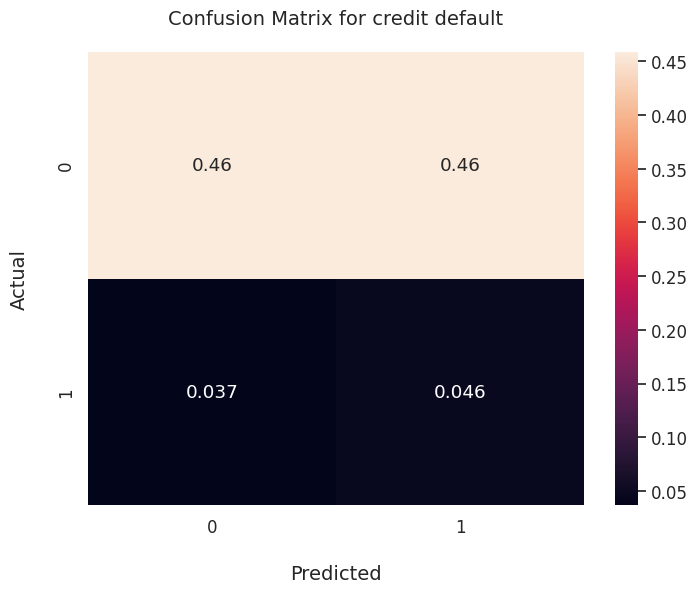

              precision    recall  f1-score   support

           0       0.93      0.50      0.65      3154
           1       0.09      0.55      0.16       284

    accuracy                           0.50      3438
   macro avg       0.51      0.53      0.40      3438
weighted avg       0.86      0.50      0.61      3438

custom score train :  2.75
custom score test :  0.8280977312390925
###################################################################################
model :  LGBMClassifier(learning_rate=0.1397316968394073, max_depth=15,
               min_child_weight=40, n_estimators=1000, num_leaves=30)
fp :  0.008144269924374637 
tn :  0.07998836532867946


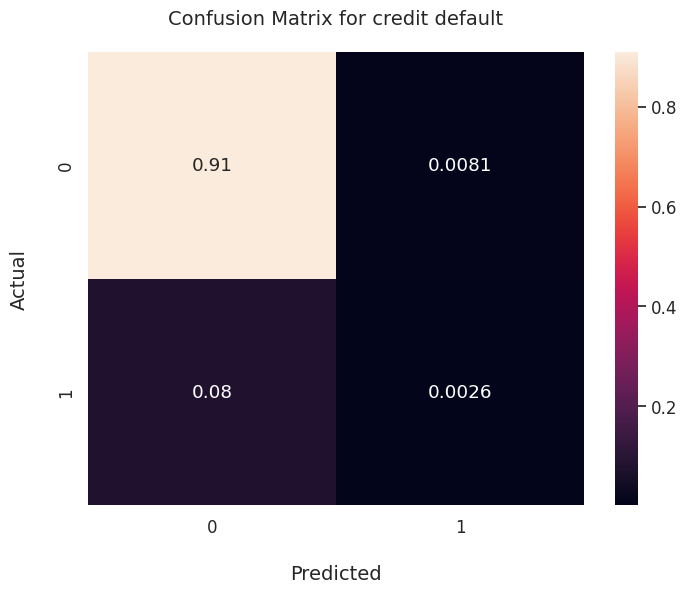

              precision    recall  f1-score   support

           0       0.92      0.99      0.95      3154
           1       0.24      0.03      0.06       284

    accuracy                           0.91      3438
   macro avg       0.58      0.51      0.50      3438
weighted avg       0.86      0.91      0.88      3438

custom score train :  0.41
custom score test :  0.8080279232111693
###################################################################################
model :  RandomForestClassifier(max_features=1, n_estimators=500)
fp :  0.00029086678301337986 
tn :  0.08260616637579989


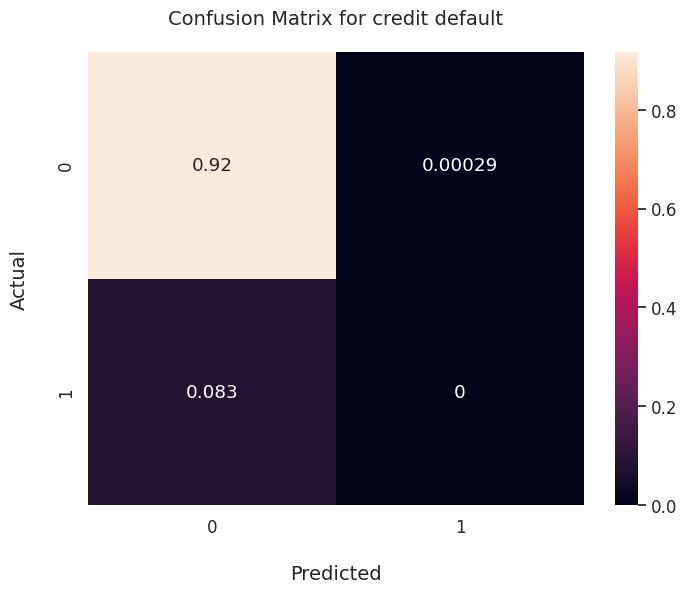

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      3154
           1       0.00      0.00      0.00       284

    accuracy                           0.92      3438
   macro avg       0.46      0.50      0.48      3438
weighted avg       0.84      0.92      0.88      3438

custom score train :  0.37
custom score test :  0.8263525305410122
###################################################################################
model :  LogisticRegression(C=0.03359818286283781, max_iter=1360)
fp :  0.0 
tn :  0.08260616637579989


/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

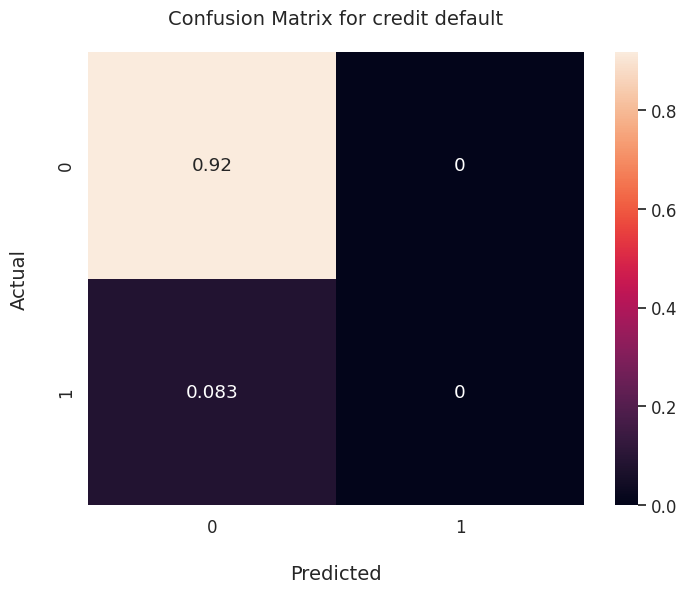

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      3154
           1       0.00      0.00      0.00       284

    accuracy                           0.92      3438
   macro avg       0.46      0.50      0.48      3438
weighted avg       0.84      0.92      0.88      3438

custom score train :  5.0
custom score test :  0.8260616637579988
###################################################################################


In [38]:
# Train/fit models and display best model evaluations, graphs and scores
from sklearn.metrics import classification_report, roc_auc_score, f1_score, accuracy_score

result_table = []

#from tqdm import tqdm
#for (name, est) in tqdm(estimators):
for (name, est) in (estimators):
    # Cross validation with RandomizedSearchCV

    score = df.shape[0]
    model=[]
    Names=[]
    
    # paramètre CV
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)    # n_splits=10, n_repeats=3
    
    # Instance RandomizedSearchCV
    clf = RandomizedSearchCV(est, 
                                param_distributions=params_list_RndSearchCV[name],
                                n_iter=10, 
                                cv=cv, 
                                scoring=custom_scorer, 
                                n_jobs=-1,    
                                random_state=42,
                                refit="custom_scorer"
                                )  

    # Fit
    clf.fit(X_, y_)

    # Predict
    y_pred = clf.best_estimator_.predict(X_test)

    # Display results
    print("model : ", clf.best_estimator_)
    confmat(y_test, y_pred)
    print(classification_report (y_test, y_pred))
    print("custom score train : ",(-clf.best_score_).round(2))
    print("custom score test : ",cost_function(y_test, y_pred))
    print('###################################################################################')
        
    fpr, tpr, threshold = det_curve(y_test, y_pred)
    result_table.append({'models':clf.best_estimator_, 
                                        #'fpr':fpr,
                                        #'tpr':tpr,
                                        'auc':roc_auc_score(y_test, y_pred),
                                        'F1':f1_score(y_test, y_pred), 
                                        'Custom Cost train':(-clf.best_score_).round(2),
                                        'Custom Cost test' :cost_function(y_test, y_pred),
                                        'Accuracy':accuracy_score(y_test, y_pred)})

In [39]:
result_table = pd.DataFrame(result_table)
result_table

,models,auc,F1,Custom Cost train,Custom Cost test,Accuracy
0,DummyClassifier(strategy='stratified'),0.526408,0.155600,2.75,0.828098,0.504363
1,LGBMClassifier(learning_rate=0.139731696839407...,0.511406,0.056075,0.41,0.808028,0.911867
2,"(DecisionTreeClassifier(max_features=1, random...",0.499841,0.000000,0.37,0.826353,0.917103
3,"LogisticRegression(C=0.03359818286283781, max_...",0.500000,0.000000,5.00,0.826062,0.917394


In [40]:
result_table.to_csv("results.csv",index=False)

In [41]:
# Enregistrement du meilleur modèle (score maison mini)
index = np.argmin(result_table['Custom Cost test'])   
       
Model_name = result_table.iloc[index, 0]
Model_name_AUC = result_table.iloc[index, 3]
Model_name_Acc = result_table.iloc[index, -1]
Model_name_Custom = result_table.iloc[index, 5]
Model_name

LGBMClassifier(learning_rate=0.1397316968394073, max_depth=15,
               min_child_weight=40, n_estimators=1000, num_leaves=30)

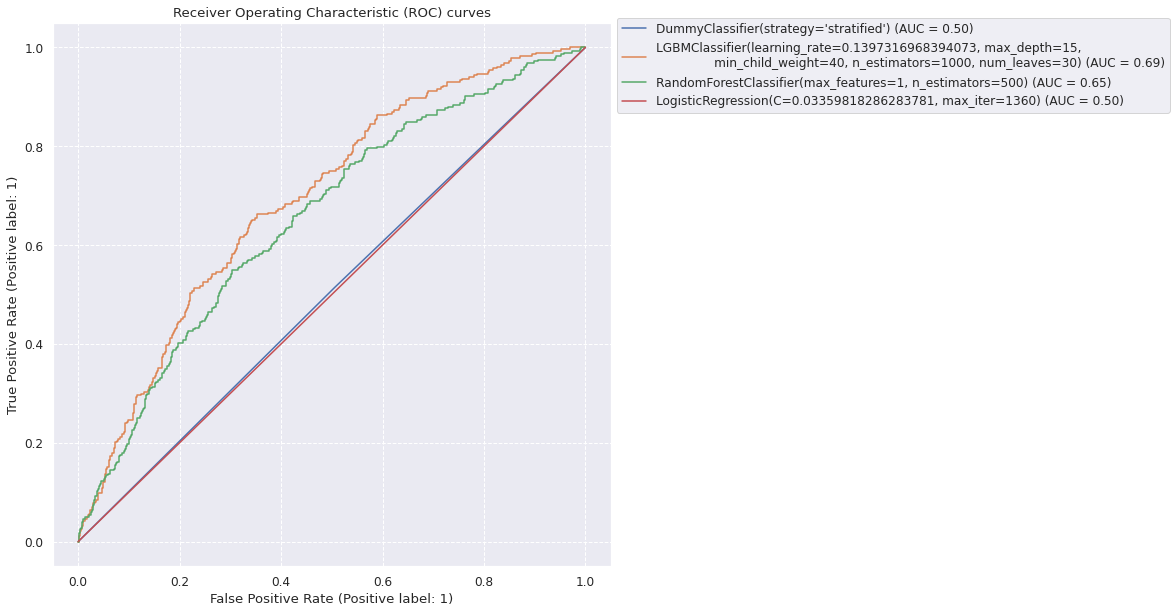

In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay

fig, ax_roc = plt.subplots(1, 1, figsize=(10, 10))

for clf in result_table.iloc[:,0]:
    clf.fit(X_, y_)

    RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax_roc, name=clf)
    #DetCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax_det, name=clf)

ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
#ax_det.set_title("Detection Error Tradeoff (DET) curves")

ax_roc.grid(linestyle="--")
#ax_det.grid(linestyle="--")

plt.legend(bbox_to_anchor=(1,1.02))
plt.show()

In [43]:
# Best Threshold and cost with best model
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
model = Model_name
# entraînez votre modèle de classification binaire
model.fit(X_, y_)

# obtenez les scores de probabilité pour votre ensemble de données de validation ou de test
y_scores = model.predict_proba(X_test)[:, 1]
range_th = np.linspace(0, 1, 101)
range_co = []
# appliquez différents seuils de classification aux scores de probabilité
for threshold in range_th:
    y_pred = (y_scores >= threshold).astype(int)

    # évaluez la performance de chaque prédiction binaire en utilisant des mesures d'évaluation
    range_co.append(cost_function(y_test, y_pred))
    best_th = range_th[argmin(range_co)]
print('Best model : ', model,'\nBest Cost on test sample): ', min(range_co),'\nBest Threshold : ',range_th[argmin(range_co)])

Best model :  LGBMClassifier(learning_rate=0.1397316968394073, max_depth=15,
               min_child_weight=40, n_estimators=1000, num_leaves=30) 
Best Cost on test sample):  0.6079115764979639 
Best Threshold :  0.02


## 4-4 : Feature importance

In [44]:
# La liste des variables hors target
feature_names = df_.columns.tolist()
#feature_names.remove('TARGET')

In [45]:
# Le meilleur modèle entraîné
Best_clf = Model_name
Best_clf.fit(X_, y_)

LGBMClassifier(learning_rate=0.1397316968394073, max_depth=15,
               min_child_weight=40, n_estimators=1000, num_leaves=30)

In [46]:
# La visualisation des important feature pour un RandomForestClassifier
feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':feature_names})

if str(Model_name).startswith('RandomForest') :

    rmodel = RandomForestClassifier()

    rmodel.fit(X_, y_)

    y_pred = rmodel.predict(X_test)


    # Vizualisation
    import matplotlib.pyplot as plt
    import seaborn as sns
    %matplotlib inline

    def plotImp(model, X , num = 20, fig_size = (40, 20)):
        feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':feature_names})
        plt.figure(figsize=fig_size)
        sns.set(font_scale = 5)
        sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                            ascending=False)[0:num])
        plt.title('RandomForestClassifier Features (avg over folds)')
        plt.tight_layout()
        plt.savefig('RF_importances-01.png')
        plt.show()

    plotImp(rmodel,X_,num = 10, fig_size = (40, 20))

    # Le dictionnaire des features importance du plus petit au plus grand
    feature_imp = pd.DataFrame({'Value':rmodel.feature_importances_,'Feature':feature_names})
    df_imp_best = feature_imp.sort_values(by="Value",ascending=False)[0:10]

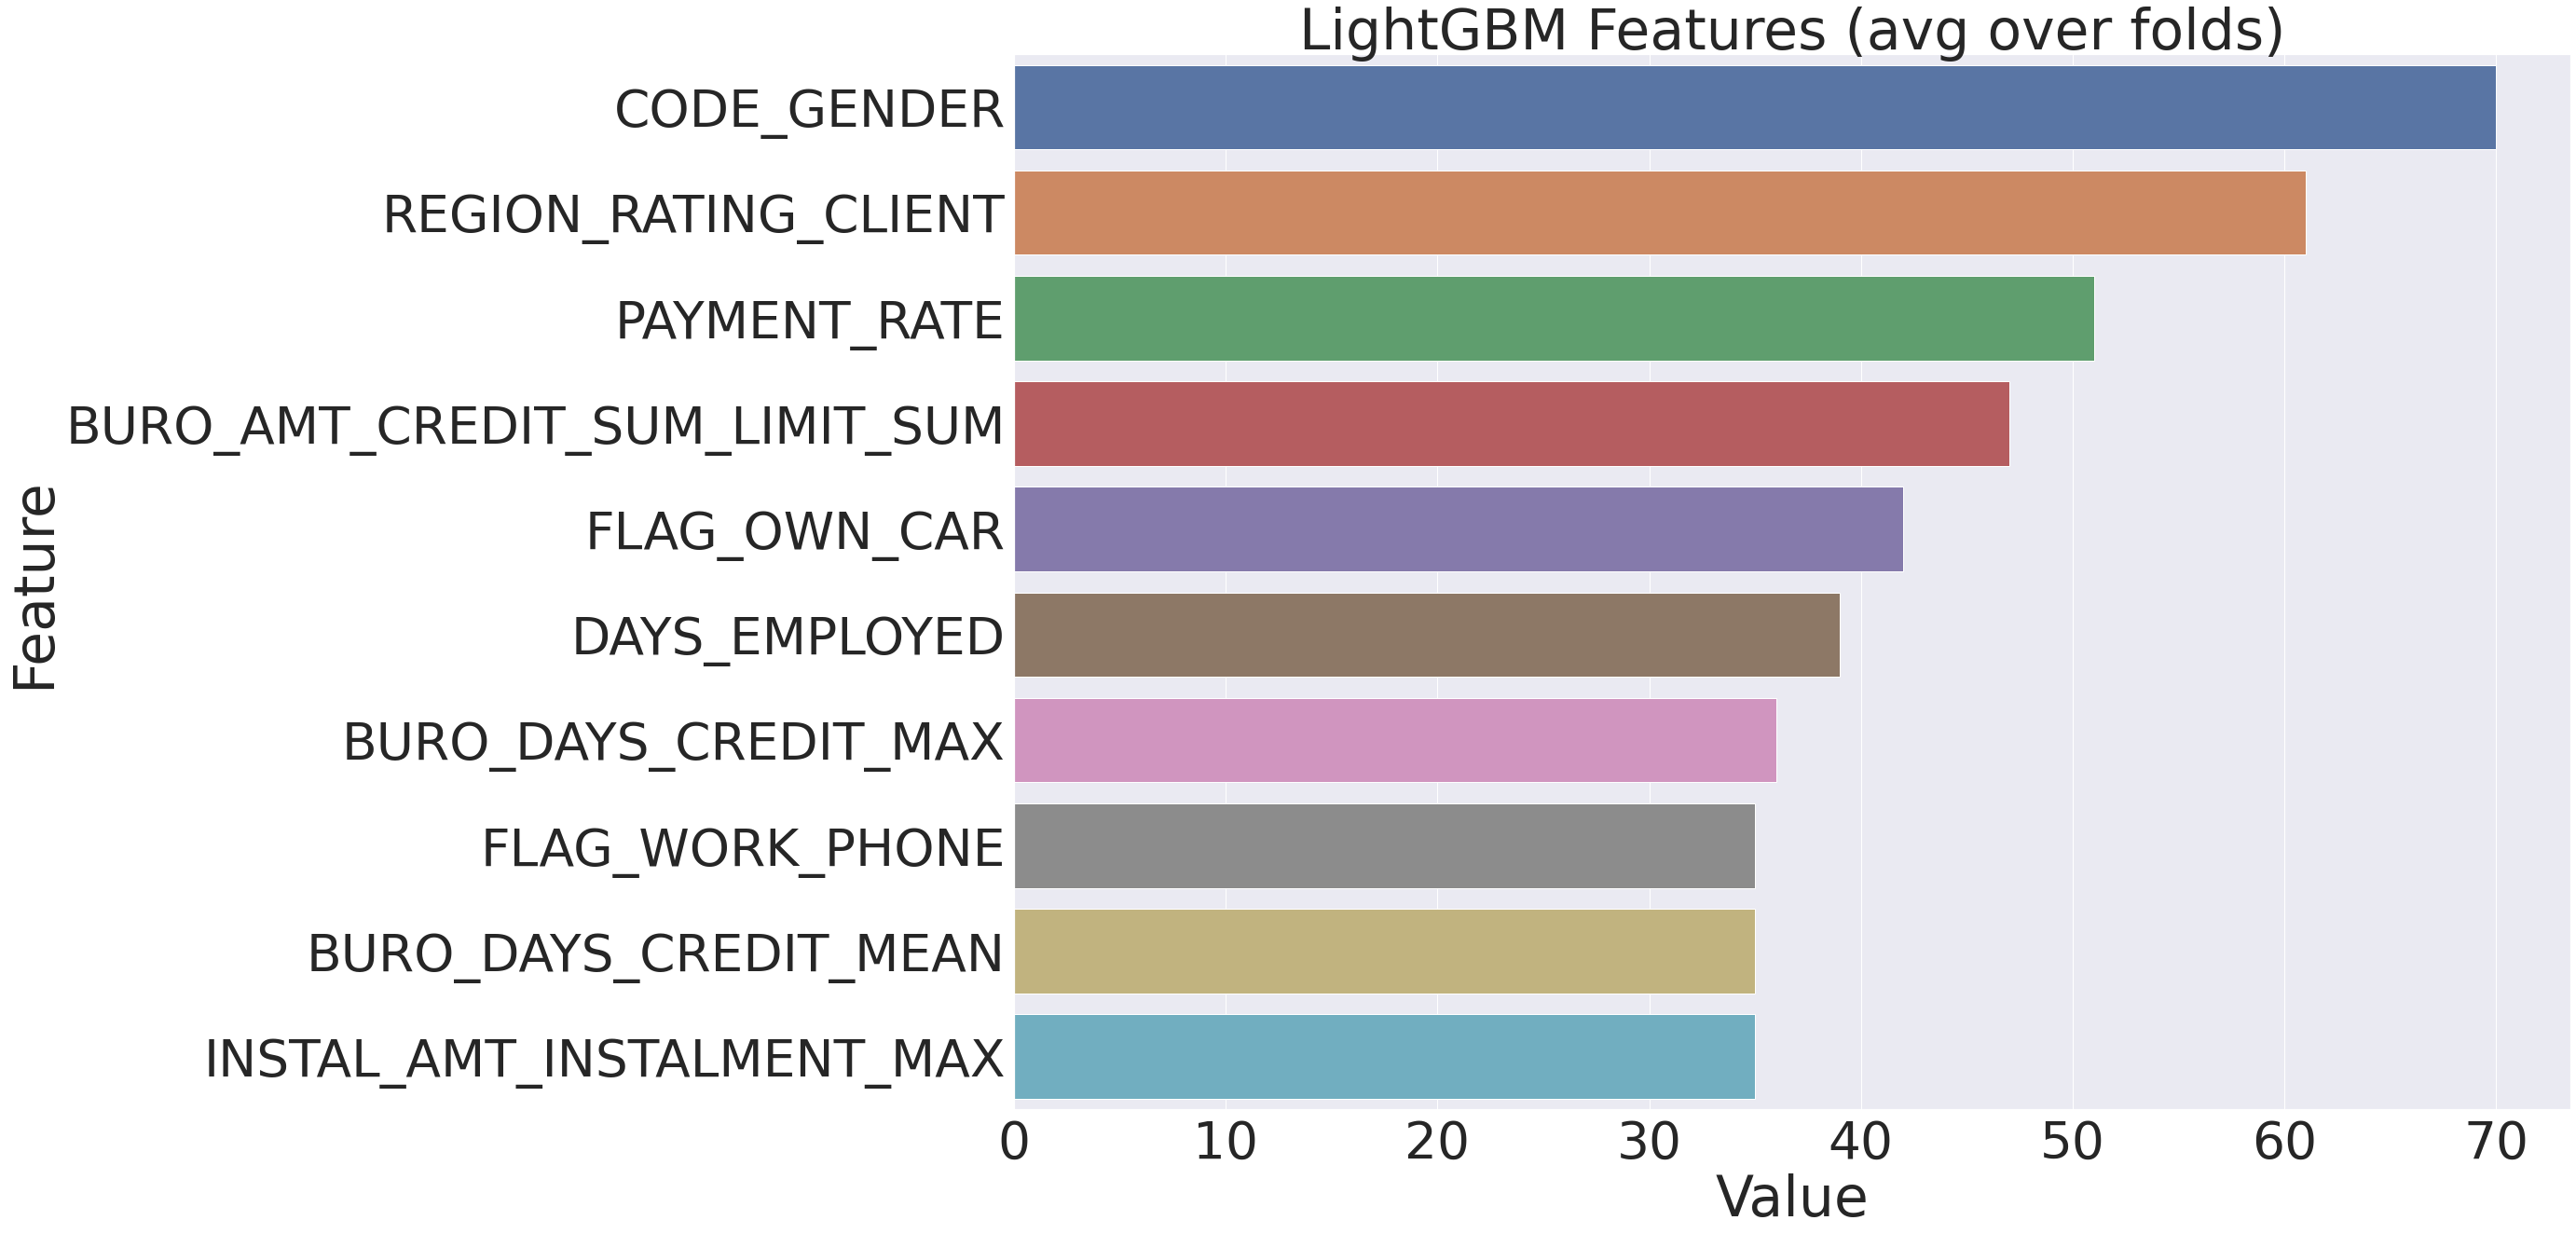

In [47]:
# La visualisation des important feature pour un LGBM
feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':feature_names})

if str(Model_name).startswith('LGBM') :
    import lightgbm

    from lightgbm import LGBMClassifier

    lgbm_model = LGBMClassifier()

    lgbm_model.fit(X_, y_)

    y_pred = lgbm_model.predict(X_test)


    # Vizualisation
    import matplotlib.pyplot as plt
    import seaborn as sns
    %matplotlib inline

    def plotImp(model, X , num = 20, fig_size = (40, 20)):
        feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':feature_names})
        plt.figure(figsize=fig_size)
        sns.set(font_scale = 5)
        sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                            ascending=False)[0:num])
        plt.title('LightGBM Features (avg over folds)')
        plt.tight_layout()
        plt.savefig('lgbm_importances-01.png')
        plt.show()

    plotImp(lgbm_model,X_,num = 10, fig_size = (40, 20))

    # Le dictionnaire des features importance du plus petit au plus grand
    feature_imp = pd.DataFrame({'Value':lgbm_model.feature_importances_,'Feature':feature_names})
    df_imp_best = feature_imp.sort_values(by="Value",ascending=False)[0:10]

## 4-5 Re-training of the best model on its 10 most important features

In [48]:
# La liste des features importantes
imp_feat = df_imp_best['Feature'].unique()
imp_feat

array(['CODE_GENDER', 'REGION_RATING_CLIENT', 'PAYMENT_RATE',
       'BURO_AMT_CREDIT_SUM_LIMIT_SUM', 'FLAG_OWN_CAR', 'DAYS_EMPLOYED',
       'BURO_DAYS_CREDIT_MAX', 'FLAG_WORK_PHONE', 'BURO_DAYS_CREDIT_MEAN',
       'INSTAL_AMT_INSTALMENT_MAX'], dtype=object)

In [49]:
# Le dataset réduit aux features importantes
feat = imp_feat.tolist()
df_i = df_.loc[:,feat]
X_i = df_i.values
y_i = df['TARGET'].values

In [50]:
# Split du dataset
X_tr, X_te, y_tr, y_te = train_test_split(X_i,y_i,test_size=0.2, random_state=42)

In [51]:
# Entraînement du modéle
Model_name.fit(X_tr, y_tr)

LGBMClassifier(learning_rate=0.1397316968394073, max_depth=15,
               min_child_weight=40, n_estimators=1000, num_leaves=30)

In [52]:
# Vérification du score
y_te_pred = Model_name.predict(X_te)
y_te_pred = (y_te_pred >= best_th)
tn, fp, fn, tp = confusion_matrix(y_te, y_te_pred, normalize='all').ravel()

# Test scoring
print('Test results: ')
print('Cost (10fn+fp): {:.2f}'.format(10*fn + fp))
print('AUC: %.2f' % roc_auc_score(y_test, y_pred))
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

Test results: 
Cost (10fn+fp): 0.72
AUC: 0.51
Accuracy: 0.92


# Part 5 : Recording model and experiment

In [53]:
# Importing libraries
import os
import mlflow
import mlflow.sklearn

In [54]:
# Define a unic name for the model to be registered with MLflow
input_string = str(Model_name)

# Trouver l'index de la parenthèse ouvrante
index = input_string.index('(')

# Extraire les premières lettres jusqu'à l'index de la parenthèse ouvrante
result = input_string[:index]

# Supprimer les espaces en trop éventuels
Model_name_str = result.strip()

from datetime import datetime

# Obtenir la date et l'heure actuelles
mtnt = datetime.now()

# Convertir la date et l'heure en string dans le format souhaité
mtnt_str = mtnt.strftime("%Y%m%d%H%M%S")

print(mtnt_str)

20230526165756


In [55]:
# Start Logging
mlflow.start_run()

<ActiveRun: >

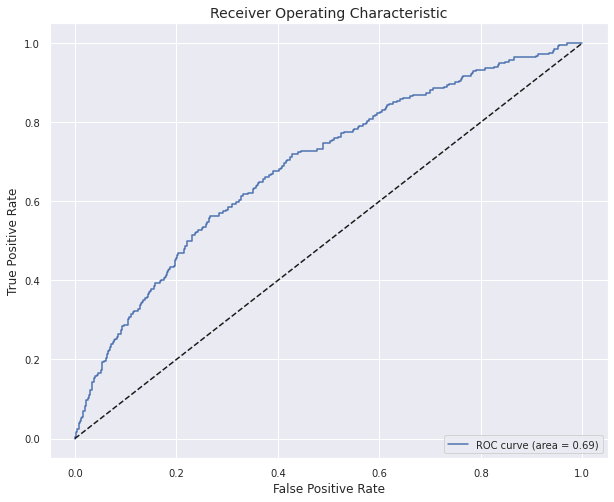

In [56]:
# Record ROC curve
y_pred_proba = Model_name.predict_proba(X_te)[:, 1]
auc = roc_auc_score(y_te, y_pred_proba)

fpr, tpr, _ = roc_curve(y_te, y_pred_proba)
# Set fontsize
# Définir la taille de la police par défaut pour les titres
plt.rcParams['axes.titlesize'] = 14

# Définir la taille de la police par défaut pour les étiquettes des axes
plt.rcParams['axes.labelsize'] = 12

# Définir la taille de la police par défaut pour les ticks des axes
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10


# Plot curve
#plt.tight_layout()
plt.figure(figsize=(10, 8))  
#matplotlib.rc('font', **font)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right', fontsize=10)
plt.savefig("roc_curve.png")
plt.show()

In [57]:
mlflow.log_artifact("roc_curve.png")

In [58]:
# Recording metrics
mlflow.log_metric("AUC", Model_name_AUC)
mlflow.log_metric("Accuracy", Model_name_Acc)
mlflow.log_metric("Custom Cost", Model_name_Custom)
mlflow.log_metric("best_threshold", best_th)

# Recording important features
mlflow.log_param("important_features", imp_feat)

# Registering the model to the workspace
print("Registering the model via MLFlow")
mlflow.sklearn.log_model(
    sk_model=Model_name,
    registered_model_name="Best_model",#registered_model_name,#args.registered_model_name,
    artifact_path="Best_model"#registered_model_name#args.registered_model_name,
)

# Saving the model to a file
mlflow.sklearn.save_model(
    sk_model=Model_name,
    path=os.path.join("Best_model", Model_name_str+mtnt_str))

# Stop Logging
mlflow.end_run()


Registering the model via MLFlow


Registered model 'Best_model' already exists. Creating a new version of this model...
2023/05/26 16:58:07 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: Best_model, version 8
Created version '8' of model 'Best_model'.


In [59]:
mlflow.end_run()


In [60]:
# Worst customer
Refused = X_te[np.argmax(y_pred_proba)].tolist()

In [61]:
# Best customer
Accepted = X_te[np.argmin(y_pred_proba)].tolist()

In [62]:
import json

variables = {
	"best_th": best_th,
	"feat": feat,
	"refused": Refused,
	"accepted": Accepted
}

with open('data.json', 'w') as file:
	json.dump(variables, file)

In [63]:
feat

['CODE_GENDER',
 'REGION_RATING_CLIENT',
 'PAYMENT_RATE',
 'BURO_AMT_CREDIT_SUM_LIMIT_SUM',
 'FLAG_OWN_CAR',
 'DAYS_EMPLOYED',
 'BURO_DAYS_CREDIT_MAX',
 'FLAG_WORK_PHONE',
 'BURO_DAYS_CREDIT_MEAN',
 'INSTAL_AMT_INSTALMENT_MAX']

In [64]:
df_ = df[feat+['SK_ID_CURR','TARGET','DAYS_BIRTH','CNT_CHILDREN']+[mot for mot in df.columns if 'FAMILY' in mot]]
df_.to_csv("df_.csv",index=False)